## Deugging function of unity-based virtual reality rig

In [189]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os.path import sep, isfile, exists
from os import mkdir, makedirs

from unityvr.preproc import logproc
from unityvr.viz import viz, utils

#### Construct data object from log file

In [190]:
#TODO: Add logging of 
# - frame rate
# - ball radius

In [191]:
dirName = '../../../../data_unityvr/raw/EPG/SS96_x_7f/EB/f01'
#"../sample/framerateTest/"
#'../../../../data_unityvr/raw/EPG/SS96_x_7f/EB/f01'
fileName = 'Log_SS96-7f-f01_EB_2LMcloserFlat_trial04_2021-02-26_19-36-25.json'
#'Log_SS96-7f-f01_EB_2LMcloserFlat_trial04_2021-02-26_19-36-25.json'
#'Log_2021-01-14_17-20-18.json'#
ftlog = 'fictrac-20210226_182924.dat'

setFramerate = 144

In [192]:
uvrTest = logproc.constructUnityVRexperiment(dirName,fileName)
uvrTest.printMetadata()

/Users/haberkernh/Documents/GitHub/unityvr/unityvr/preproc/logproc.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nidDf.imgfFilt[np.isfinite(nidDf.imgfsig)] = medfilt(nidDf.imgfsig[np.isfinite(nidDf.imgfsig)])


Metadata:

expid  :  SS96
experiment  :  projectors on. 144 Hz frame rate with force render rate on, SS96_x_7f, 2LM close (very close) with flat background ~
genotype  :  SS96_x_7f ~
sex  :  f ~age:5
flyid  :  f01 ~
trial  :  trial04
date  :  2021-02-26
time  :  19-36-25
notes  :  EB imaging ~trial:04


In [193]:
dat = logproc.openUnityLog(dirName, fileName)
ftdat = logproc.ftDfFromLog(dat)
print(dat[0])

{'timeSecs': 1.9235854148864746, 'frame': 262.0, 'timeSecsAfterSplash': 1.9235854148864746, 'frameAfterSplash': 262.0, 'headerNotes': '~expid:SS96-x-7f_2LMcloseFlat ~experiment:projectors on. 144 Hz frame rate with force render rate on, SS96_x_7f, 2LM close (very close) with flat background ~genotype:SS96_x_7f ~flyid:f01 ~sex:f ~age:5-8d ~notes:EB imaging ~trial:04     '}


### Check frame rate
#### Basic visualizations

In [194]:
framesDf = uvrTest.nidDf[['frame','time','dt']].drop_duplicates().reset_index(level=0)[['frame','time','dt']]

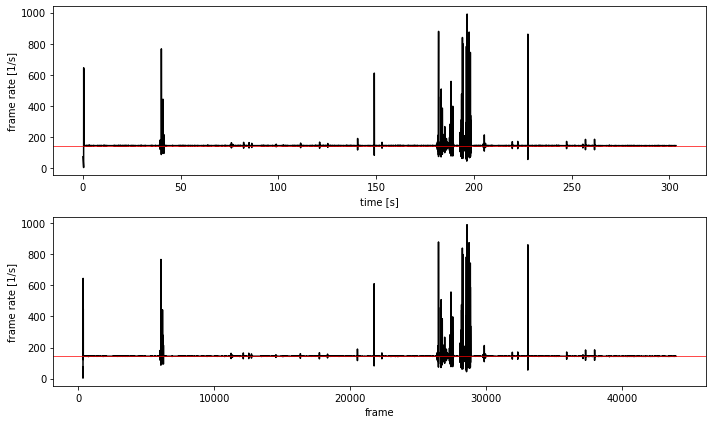

In [195]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
ax[0].plot(framesDf.time, 1/framesDf.dt, 'k')
ax[1].plot(framesDf.frame, 1/framesDf.dt, 'k')
for i in range(2):ax[i].axhline(setFramerate,0,1,color='r', linewidth=0.7)
utils.addlabs(ax, ['time [s]','frame'], ['frame rate [1/s]','frame rate [1/s]'])
fig.tight_layout()

utils.makemydir(sep.join([dirName,'plots']))
fig.savefig(sep.join([dirName,'plots','framerate_'+fileName.split('.')[0]+'.pdf']))

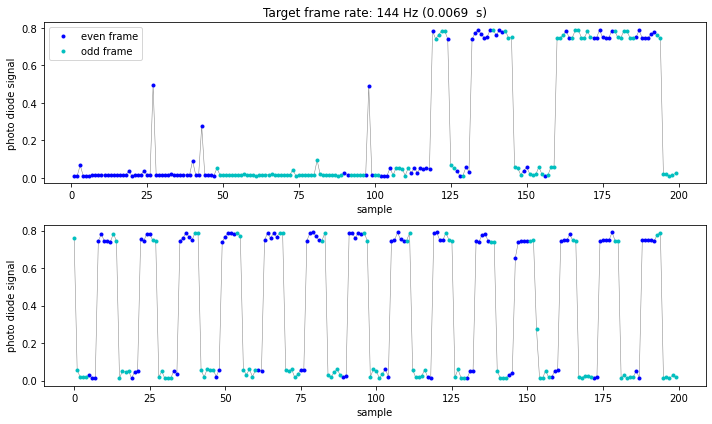

In [196]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
wind = 200
for i, ts in enumerate([0,5000]):
    ax[i].plot(range(wind),uvrTest.nidDf.pdsig[ts:ts+wind],'-',color='grey',linewidth=0.5)
    
    even = uvrTest.nidDf[ts:ts+wind][uvrTest.nidDf['frame'][ts:ts+wind]%2==1]
    ax[i].plot(np.arange(wind)[uvrTest.nidDf['frame'][ts:ts+wind].values%2==1], even.pdsig, 'b.', label='even frame')
    
    odd = uvrTest.nidDf[ts:ts+wind][uvrTest.nidDf['frame'][ts:ts+wind]%2==0]
    ax[i].plot(np.arange(wind)[uvrTest.nidDf['frame'][ts:ts+wind].values%2==0], odd.pdsig, 'c.', label=
              'odd frame')
    
utils.addlabs(ax, ['sample','sample'], ['photo diode signal','photo diode signal'])
ax[0].legend()
ax[0].set_title('Target frame rate: {} Hz ({}  s)'.format(setFramerate, round(1/setFramerate, 4)))
fig.tight_layout()

utils.makemydir(sep.join([dirName,'plots']))
fig.savefig(sep.join([dirName,'plots','photodiodeSig_evenframe_'+fileName.split('.')[0]+'.pdf']))

Visualization of delay

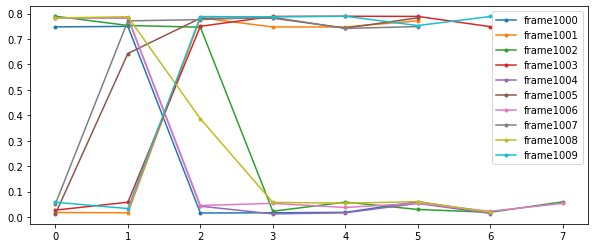

In [197]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
for f in range(1000,1010):
    sig = uvrTest.nidDf.query('frame == '+str(float(f)))
    ax.plot(range(len(sig.pdsig)), sig.pdsig, '.-',  label='frame{}'.format(f))
ax.legend()

#### Quantification of frame rate variation

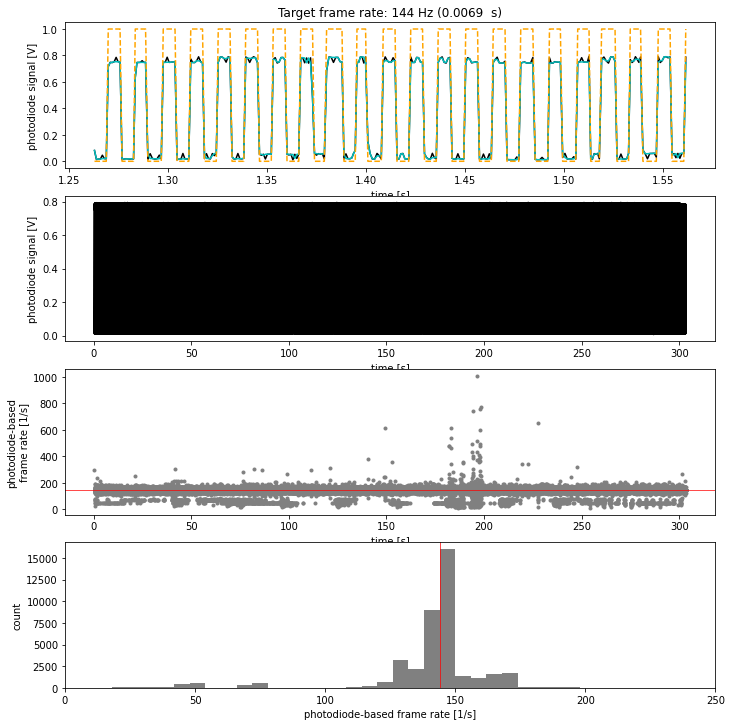

In [198]:
fig, ax = plt.subplots(4,1, figsize=(10,10))
ts = 1000
wind = 300
ax[0].plot(uvrTest.nidDf.timeinterp[ts:ts+wind], uvrTest.nidDf.pdsig[ts:ts+wind], 'k')
ax[0].plot(uvrTest.nidDf.timeinterp[ts:ts+wind], uvrTest.nidDf.pdFilt[ts:ts+wind], 'c')
ax[0].plot(uvrTest.nidDf.timeinterp[ts:ts+wind], uvrTest.nidDf.pdThresh[ts:ts+wind], '--',color='orange')

pdChange = np.hstack((0,np.diff(uvrTest.nidDf.pdThresh)))
pdChangeT = uvrTest.nidDf.timeinterp.values[abs( pdChange )>0]

ax[1].plot(uvrTest.nidDf.timeinterp, uvrTest.nidDf.pdsig, 'k')

ax[2].plot(pdChangeT[1:], 1/np.diff(pdChangeT), '.', color='grey')
ax[2].axhline(setFramerate,0,1,color='r', linewidth=0.7)

ax[3].hist(1/np.diff(pdChangeT), bins=50, range=(0, 300), color='grey')
ax[3].set_xlim(0,250)
ax[3].axvline(setFramerate,0,1,color='r', linewidth=0.7)

ax[0].set_title('Target frame rate: {} Hz ({}  s)'.format(setFramerate, round(1/setFramerate, 4)))

fig.tight_layout()
utils.addlabs(ax, ['time [s]','time [s]','time [s]','photodiode-based frame rate [1/s]'],
    ['photodiode signal [V]','photodiode signal [V]','photodiode-based\nframe rate [1/s]','count'])

utils.makemydir(sep.join([dirName,'plots']))
fig.savefig(sep.join([dirName,'plots','photdiodeSignal_framerate_'+fileName.split('.')[0]+'.pdf']))

#### Relate unity-based and photodiode signal-based frame rate measures

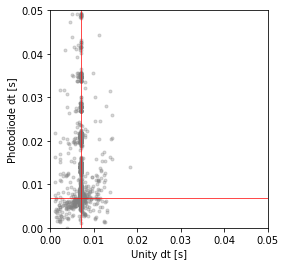

In [199]:
pdChangedt = uvrTest.nidDf.dt.values[abs( pdChange )>0]

fig, axs = plt.subplots(1,1,figsize=(4,4))

axs.plot(np.roll(pdChangedt,0), np.hstack((0,np.diff(pdChangeT))), '.', color='grey', alpha=0.3)
#axs.plot(np.roll(pdChangedt,10), np.hstack((0,np.diff(pdChangeT))), 'r.', alpha=0.5)
axs.set_xlim(0,0.05)
axs.set_ylim(0,0.05)
axs.set_xlabel('Unity dt [s]')
axs.set_ylabel('Photodiode dt [s]')
axs.axvline(1/setFramerate,0,1,color='r', linewidth=0.7)
axs.axhline(1/setFramerate,0,1,color='r', linewidth=0.7)
axs.set_aspect('equal')
ax[0].set_title('Target frame rate: {} Hz ({}  s)'.format(setFramerate, round(1/setFramerate, 4)))

utils.makemydir(sep.join([dirName,'plots']))
fig.savefig(sep.join([dirName,'plots','unityVsPhotodiode_framerate_'+fileName.split('.')[0]+'.pdf']))

### Compare unityVR trajectory with fictrac trajectory
#### Compare frame rates

Unity log frame rate: 143.8511974405843
Fictrac log frame rate: 146.23050544599334


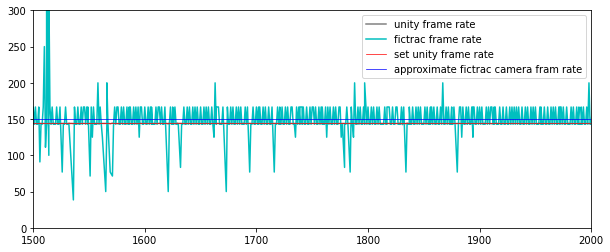

In [200]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.plot(uvrTest.posDf.frame, 1/uvrTest.posDf.dt, color='grey', label="unity frame rate")
ax.plot(uvrTest.ftDf.frame,np.hstack([ 0, 1/np.diff(uvrTest.ftDf.ficTracTReadMs/1000.) ]), 'c-', label='fictrac frame rate')
print('Unity log frame rate: {}'.format(1/uvrTest.posDf.dt.mean()))
print('Fictrac log frame rate: {}'.format(1/np.diff(uvrTest.ftDf.ficTracTReadMs/1000.).mean()))
ax.set_xlim(1500,2000)
ax.set_ylim(0,300)
ax.axhline(setFramerate,0,1,color='r', linewidth=0.7, label='set unity frame rate')
ax.axhline(150,0,1,color='b', linewidth=0.7, label="approximate fictrac camera fram rate")
ax.legend()

#### Compare to fictrac data log

In [201]:
ftdat = pd.read_csv(sep.join([dirName, ftlog]), header=None)

In [202]:
ftdat.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,3445283599811,0,0,6.656502e+07
1,1,-0.013229,0.000000,0.000000,4755.897661,-0.013221,-0.000441,-0.000009,-0.013229,0.000000,...,0.013221,0.000009,1.604170,0.013229,-0.000441,0.013221,3445290201292,1,6601481,6.656502e+07
2,2,-0.002833,0.003155,-0.003570,4617.743266,-0.002687,-0.004380,-0.002078,-0.016061,0.003179,...,0.015903,0.002087,2.591439,0.005139,-0.004822,0.015908,3445296802692,2,6601400,6.656503e+07
3,3,0.000810,0.003438,0.001472,4653.691297,0.000796,0.000518,-0.003707,-0.015260,0.006606,...,0.015110,0.005794,5.289324,0.000950,-0.004304,0.015112,3445303404499,3,6601807,6.656503e+07
4,4,-0.001245,0.003782,0.000680,4592.276261,-0.001229,-0.000406,-0.003826,-0.016510,0.010382,...,0.016336,0.009620,1.889438,0.001294,-0.004709,0.016341,3445310005940,4,6601441,6.656504e+07


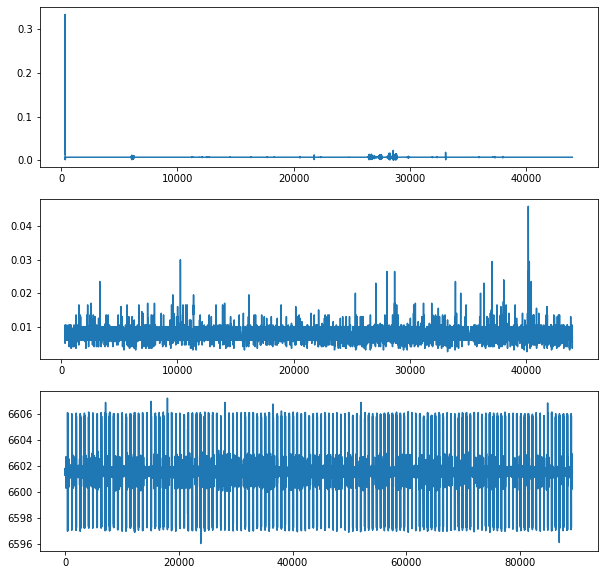

In [203]:
fig, axs = plt.subplots(3,1, figsize=(10,10))

axs[0].plot(uvrTest.posDf.frame,uvrTest.posDf.dt)
axs[1].plot(uvrTest.ftDf.frame, np.gradient(uvrTest.ftDf.ficTracTReadMs/1000.))

ftdt = ftdat[23].values/1000.
axs[2].plot(ftdat[0].values[1:-1], ftdt[1:-1])

#### Vizualize trajectory and object positions
ToDo: interpolate ft to get to frame rate of fictrac --> replace ftdf downsampling function

In [259]:
ballr = 0.047 
convfmm = 100

print(ballr*convfmm)

convf = ballr * convfmm #* 180/np.pi

4.7


In [260]:
uvrTest.ftDf.head()

,frame,ficTracTReadMs,ficTracTWriteMs,dx,dy,dz
0,336.0,0.0,0.0,-0.001443,-0.030257,0.036151
1,336.0,6.0,6601441.0,0.017000,-0.029775,0.039995
2,336.0,12.0,13203124.0,0.002571,0.017497,0.051510
3,336.0,19.0,19804483.0,-0.000292,-0.001085,0.049460
4,336.0,27.0,26406209.0,-0.012654,0.013383,0.004144


In [261]:
ftdat.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,3445283599811,0,0,6.656502e+07
1,1,-0.013229,0.000000,0.000000,4755.897661,-0.013221,-0.000441,-0.000009,-0.013229,0.000000,...,0.013221,0.000009,1.604170,0.013229,-0.000441,0.013221,3445290201292,1,6601481,6.656502e+07
2,2,-0.002833,0.003155,-0.003570,4617.743266,-0.002687,-0.004380,-0.002078,-0.016061,0.003179,...,0.015903,0.002087,2.591439,0.005139,-0.004822,0.015908,3445296802692,2,6601400,6.656503e+07
3,3,0.000810,0.003438,0.001472,4653.691297,0.000796,0.000518,-0.003707,-0.015260,0.006606,...,0.015110,0.005794,5.289324,0.000950,-0.004304,0.015112,3445303404499,3,6601807,6.656503e+07
4,4,-0.001245,0.003782,0.000680,4592.276261,-0.001229,-0.000406,-0.003826,-0.016510,0.010382,...,0.016336,0.009620,1.889438,0.001294,-0.004709,0.016341,3445310005940,4,6601441,6.656504e+07


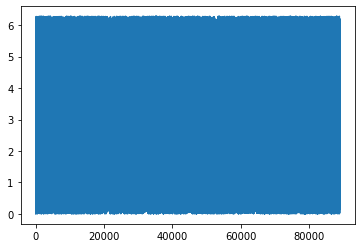

In [262]:
TV = np.mod(np.unwrap(ftdat[16])+np.unwrap(ftdat[17]), 2*np.pi)
plt.plot(TV)

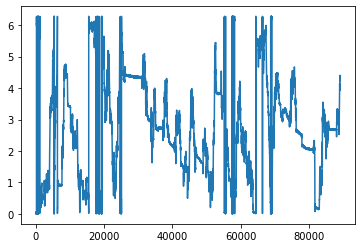

In [341]:
plt.plot(np.mod(fthead, 2*np.pi))

In [363]:
#raw ft values
ftts = np.gradient(ftdat[24].values)/1000#ftdat[23].values/1000 #dt in seconds
fta_raw = -ftdat[7].values
fts_raw = ftdat[5].values * convf #ftdat[19].values * convf
ftf_raw = ftdat[6].values * convf #ftdat[20].values * convf

fthead = np.cumsum(fta_raw)
ftdy_raw = -fts_raw * np.cos(fthead) - ftf_raw * np.sin(fthead)
ftdx_raw = fts_raw * np.sin(fthead) + ftf_raw * np.cos(fthead)

ftxpos_raw = np.cumsum(ftdx_raw)
ftypos_raw = np.cumsum(ftdy_raw)

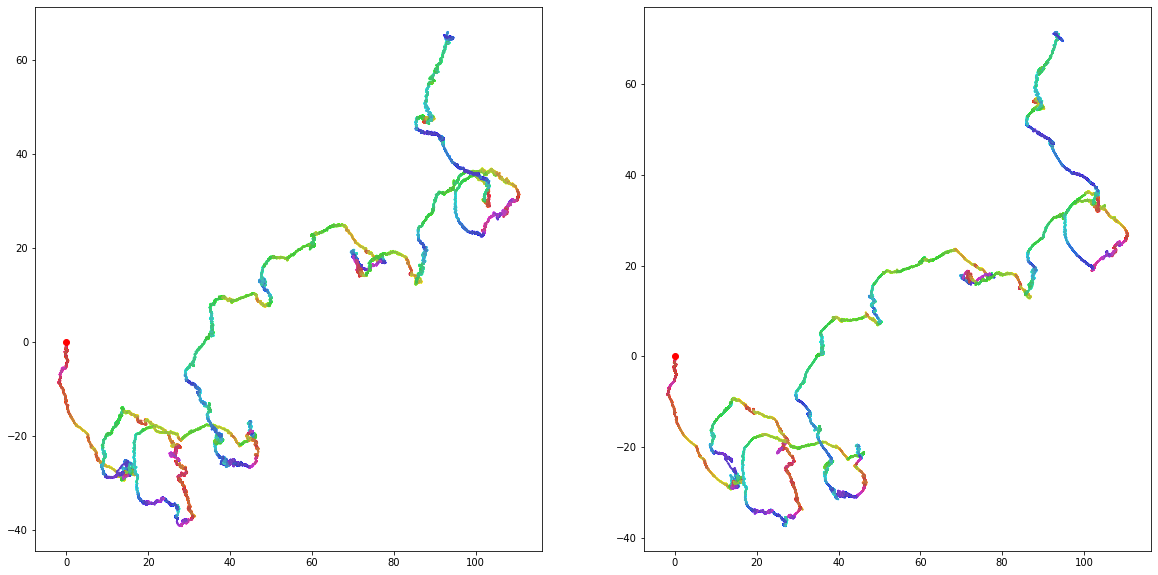

In [364]:
fig, axs = plt.subplots(1,2, figsize=(20,10))
axs[0].plot(ftdat[14]*convf,ftdat[15]*convf,'-',color='grey',alpha=0.5)
axs[0].scatter(ftdat[14]*convf,ftdat[15]*convf,c=np.mod(fthead, 2*np.pi), s=1, cmap='hsv')
#axs[0].scatter(ftdat[14]*convf,ftdat[15]*convf,c=ftdat[0], s=1, cmap='inferno')
axs[0].plot(ftdat[14][0]*convf,ftdat[15][0]*convf,'ro')

axs[1].plot(ftxpos_raw,ftypos_raw,'-',color='grey',alpha=0.5)
axs[1].scatter(ftxpos_raw,ftypos_raw,c=np.mod(fthead, 2*np.pi), s=1, cmap='hsv')
#axs[1].scatter(ftxpos_raw,ftypos_raw,c=ftdat[0], s=1, cmap='inferno')
axs[1].plot(ftxpos_raw[0],ftypos_raw[0],'ro')

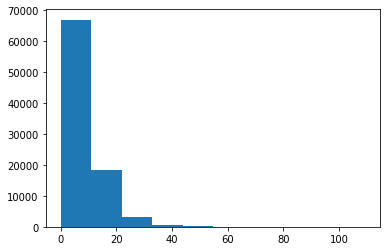

In [367]:
plt.hist((1/ftts[1:])*np.hypot(np.diff(ftdat[14]*convf),np.diff(ftdat[15]*convf)));

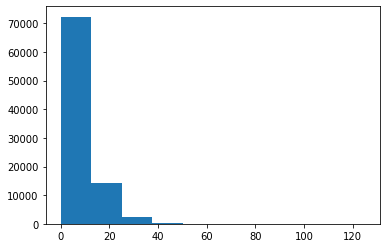

In [368]:
plt.hist((1/ftts)*np.hypot(ftdx_raw,ftdy_raw));

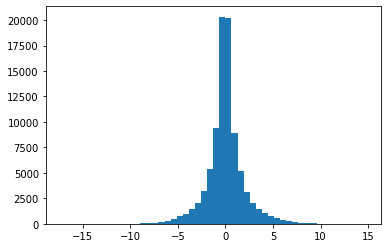

In [370]:
plt.hist((1/ftts[1:])*np.diff(fthead), bins=50);

In [210]:
fta = np.cumsum(uvrTest.ftDf['dz'])
ftf = uvrTest.ftDf['dx'] * convf
fts =uvrTest.ftDf['dy'] * convf

ftdx = -ftf*np.cos(fta) - fts*np.sin(fta)
ftdy = ftf*np.sin(fta) + fts*np.cos(fta)

ftxpos = np.cumsum(ftdx)
ftypos = np.cumsum(ftdy)

4.7


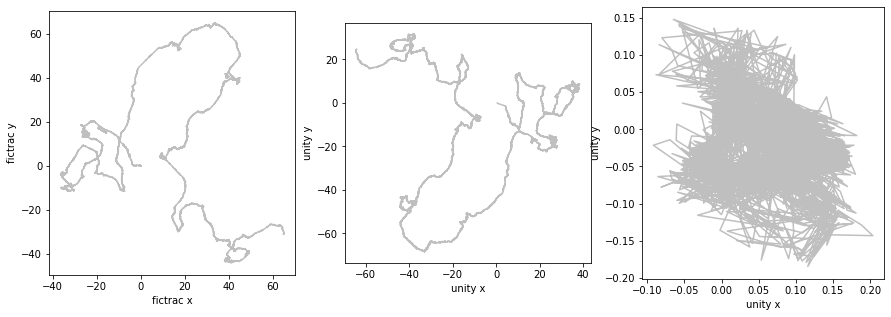

In [211]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

#plt.plot(posDf['x'], posDf['y'],color='grey',alpha=0.5)
#plt.scatter(posDf['x'], posDf['y'],s=7,c=posDf['time'],cmap='viridis')

axs[0].plot(ftxpos, ftypos,color='grey',alpha=0.5)
#axs[0].scatter(ftxpos, ftypos,s=7,c=uvrTest.ftDf['frame'],cmap='viridis')
axs[0].set_xlabel('fictrac x')
axs[0].set_ylabel('fictrac y')
axs[0].set_aspect('equal')

axs[1].plot(uvrTest.posDf['x']*convfmm, uvrTest.posDf['y']*convfmm,color='grey',alpha=0.5)
#axs[1].scatter(uvrTest.posDf['x']*convfmm, uvrTest.posDf['y']*convfmm,s=7,c=uvrTest.posDf['time'],cmap='viridis')
axs[1].set_xlabel('unity x')
axs[1].set_ylabel('unity y')
axs[1].set_aspect('equal')

axs[2].plot(ftxpos_raw,ftypos_raw,color='grey',alpha=0.5)
#axs[2].scatter(uvrTest.posDf['x']*convfmm, uvrTest.posDf['y']*convfmm,s=7,c=uvrTest.posDf['time'],cmap='viridis')
axs[2].set_xlabel('unity x')
axs[2].set_ylabel('unity y')
axs[2].set_aspect('equal')

utils.makemydir(sep.join([dirName,'plots']))
fig.savefig(sep.join([dirName,'plots','trajectoryComparison_'+fileName.split('.')[0]+'.pdf']))

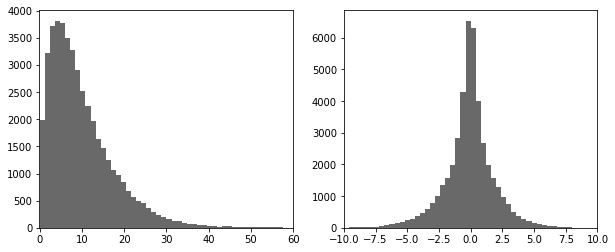

In [212]:
ftvt = np.hypot(ftx, fty) * (1000/np.gradient(uvrTest.ftDf['ficTracTReadMs']))
ftvr = np.gradient(np.unwrap(fta)) * setFramerate

fig, axs = plt.subplots(1,2,figsize=(10,4))
axs[0].hist(ftvt ,bins=50,range=(0,60),color='dimgrey')
axs[0].set_xlim(-0.1,60)

axs[1].hist(ftvr ,bins=50,range=(-10,10), color='dimgrey')
axs[1].set_xlim(-10,10);

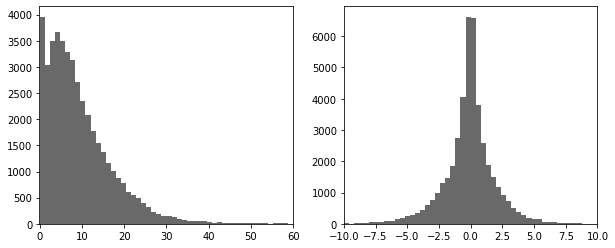

In [213]:
ftvt = np.hypot(np.diff(uvrTest.posDf['x']*convfmm), np.diff(uvrTest.posDf['y']*convfmm)) * setFramerate
ftvr = np.gradient(np.unwrap(uvrTest.posDf['angle']*np.pi/180-np.pi)) * setFramerate

fig, axs = plt.subplots(1,2,figsize=(10,4))
axs[0].hist(ftvt ,bins=50, range=(0,60), color='dimgrey')
axs[0].set_xlim(-0.1,60)

axs[1].hist(ftvr, bins=50,range=(-10,10),color='dimgrey');
axs[1].set_xlim(-10,10);

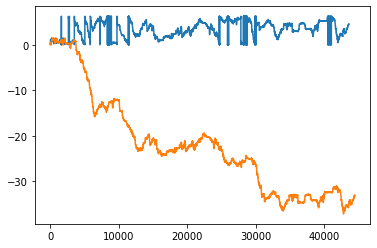

In [65]:
plt.plot(uvrTest.posDf['angle']*np.pi/180)
plt.plot(fta)

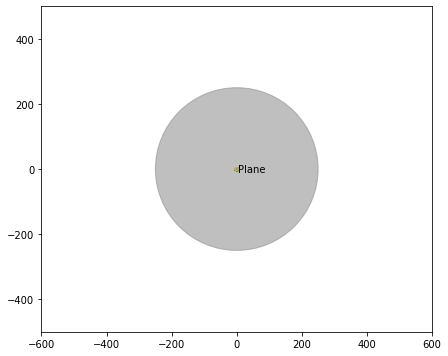

In [176]:
fig = viz.plotVRpathWithObjects(uvrTest, limx=[-600,600], limy=[-500,500],myfigsize=(7,7))

### Microscope trigger:

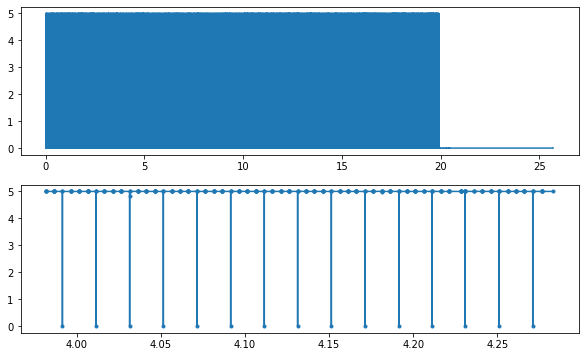

In [19]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
wind = 300
ts = 4000
ax[0].plot(uvrTest.nidDf.time.values,uvrTest.nidDf.imgfsig.values)
ax[1].plot(uvrTest.nidDf.time.values[ts:ts+wind],uvrTest.nidDf.imgfsig.values[ts:ts+wind],'.-')

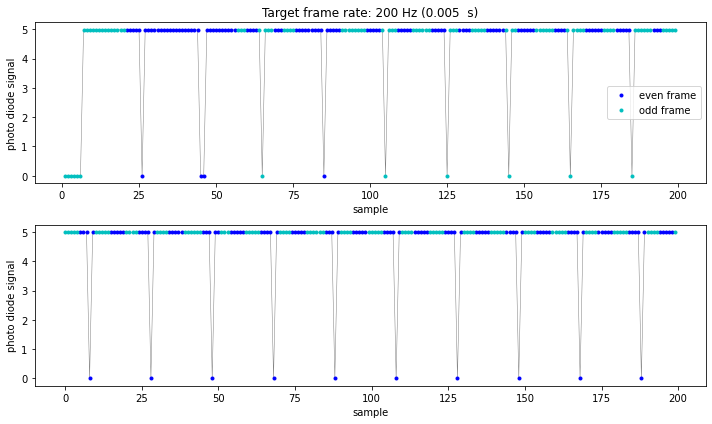

In [20]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
wind = 200
for i, ts in enumerate([0,5000]):
    ax[i].plot(range(wind),uvrTest.nidDf.imgfsig[ts:ts+wind],'-',color='grey',linewidth=0.5)
    
    even = uvrTest.nidDf[ts:ts+wind][uvrTest.nidDf['frame'][ts:ts+wind]%2==1]
    ax[i].plot(np.arange(wind)[uvrTest.nidDf['frame'][ts:ts+wind].values%2==1], even.imgfsig, 'b.', label='even frame')
    
    odd = uvrTest.nidDf[ts:ts+wind][uvrTest.nidDf['frame'][ts:ts+wind]%2==0]
    ax[i].plot(np.arange(wind)[uvrTest.nidDf['frame'][ts:ts+wind].values%2==0], odd.imgfsig, 'c.', label=
              'odd frame')
    
utils.addlabs(ax, ['sample','sample'], ['photo diode signal','photo diode signal'])
ax[0].legend()
ax[0].set_title('Target frame rate: {} Hz ({}  s)'.format(setFramerate, round(1/setFramerate, 4)))
fig.tight_layout()


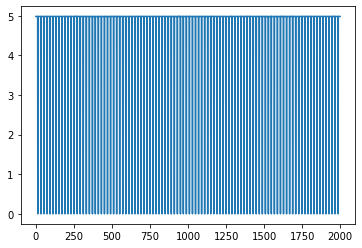

In [21]:
plt.plot(uvrTest.nidDf.imgfsig.values[-8000:-6000])

In [22]:
imgFrame = uvrTest.nidDf.frame[np.where(np.diff(uvrTest.nidDf.imgfsig.values)>3)[0]]

In [23]:
imgFrame.size

1000